In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [12]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [13]:
# Choose which elements to search on
elts = elts_pert

In [14]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [15]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [16]:
# Review nearest asteroid to these candidate elements
# elts_near

In [17]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [18]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [19]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [20]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [21]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [22]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [23]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [24]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [25]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [26]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [27]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [28]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [29]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [30]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.36  :   0.00 :  1800.46 :  7200.00
Mean     :     0.36  :   0.00 :  1800.46 :  7200.00
Median   :     0.25  :   0.00 :  1807.21 :  7200.00
GeoMean  :     1.10  :   0.00 :  1800.45 :  7200.99
Min      :    -0.96  :   0.00 :  1792.81 :  7200.00
Max      :     3.72  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 3200 samples
Epoch 1/4
3200/3200 [==============================] - 3s 915us/sample - loss: -18019.7872
Epoch 2/4
3200/3200 [==============================] - 1s 387us/sample - loss: -24653.1882
Epoch 3/4
3200/3200 [==============================] - 1s 395us/sample - loss: -32039.1932
Epoch 4/4
3200/3200 [==============================] - 1s 384us/sample - loss: -40237.4618
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1771.45 :  1771.45 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      1.07 :     1.07 :      nan
Mean Hits           :      0.00

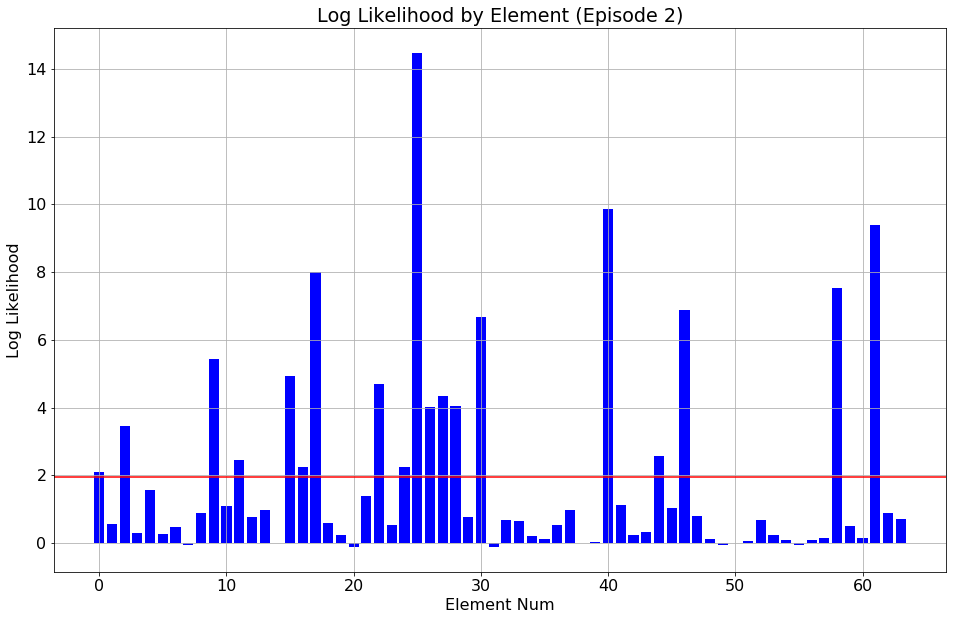

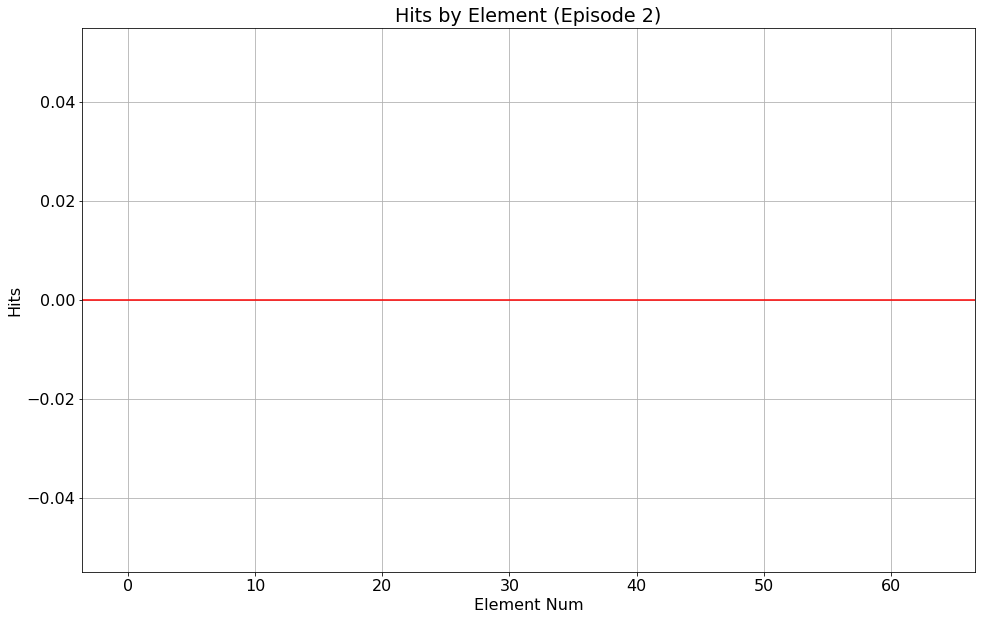


********************************************************************************
Round 2: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    400
effective_learning_rate=1.526e-05, training_time 20 sec.
Train on 3200 samples
Epoch 9/12
3200/3200 [==============================] - 5s 2ms/sample - loss: -201441.6517
Epoch 10/12
3200/3200 [==============================] - 2s 512us/sample - loss: -262680.6763
Epoch 11/12
3200/3200 [==============================] - 2s 485us/sample - loss: -290777.3069
Epoch 12/12
3200/3200 [==============================] - 2s 469us/sample - loss: -305252.6375
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1670.50 :  1670.50 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      7.44 :

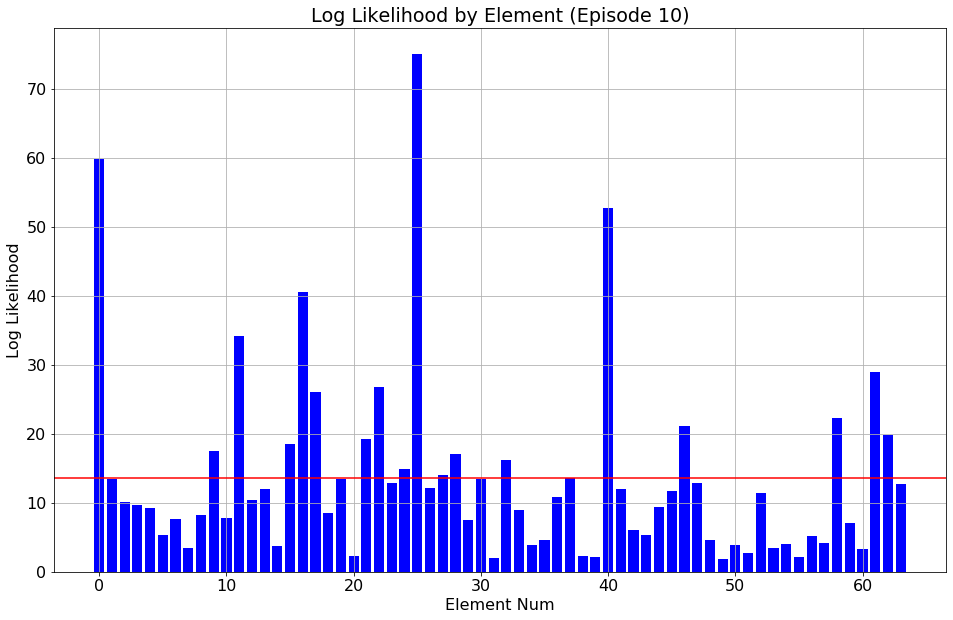

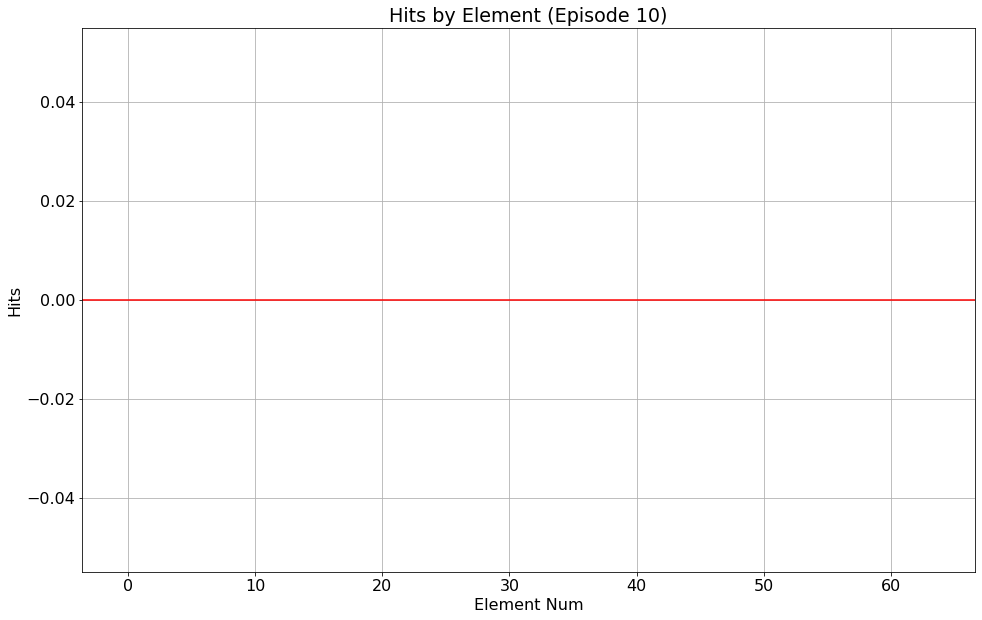


********************************************************************************
Round 3: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2000
effective_learning_rate=1.526e-05, training_time 91 sec.
Train on 3200 samples
Epoch 41/44
3200/3200 [==============================] - 3s 1ms/sample - loss: -734128.9975
Epoch 42/44
3200/3200 [==============================] - 2s 496us/sample - loss: -869996.9038
Epoch 43/44
3200/3200 [==============================] - 2s 495us/sample - loss: -1035030.5450
Epoch 44/44
3200/3200 [==============================] - 2s 505us/sample - loss: -1264738.1325
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    921.74 :   921.74 :      nan arc seconds
Geom Mean Threshold :   5379.94 :  5379.94 :      nan arc seconds
Mean Log Likelihood :     17.72 :    17.72 :      nan
Mean Hits        

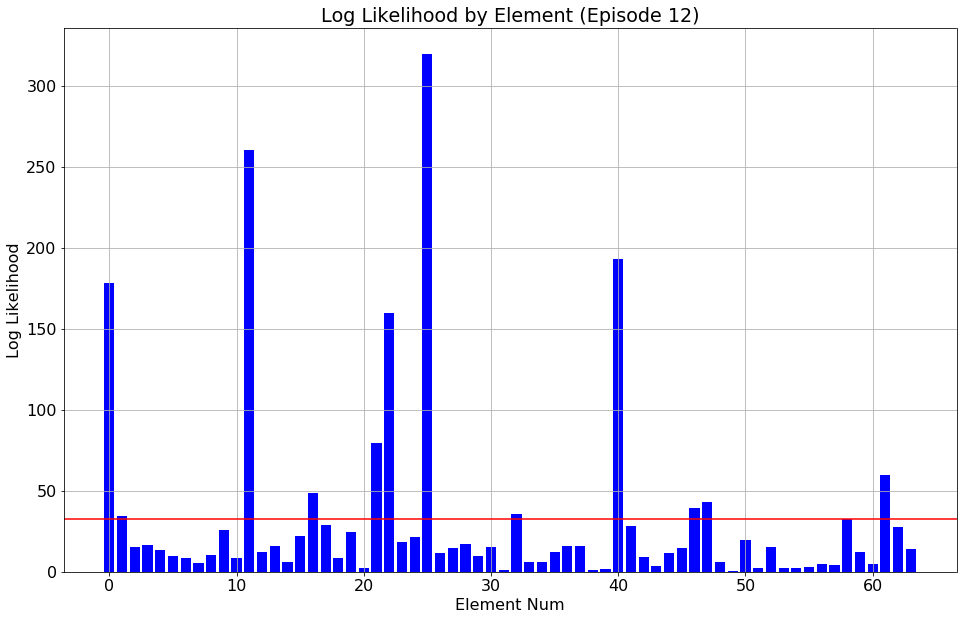

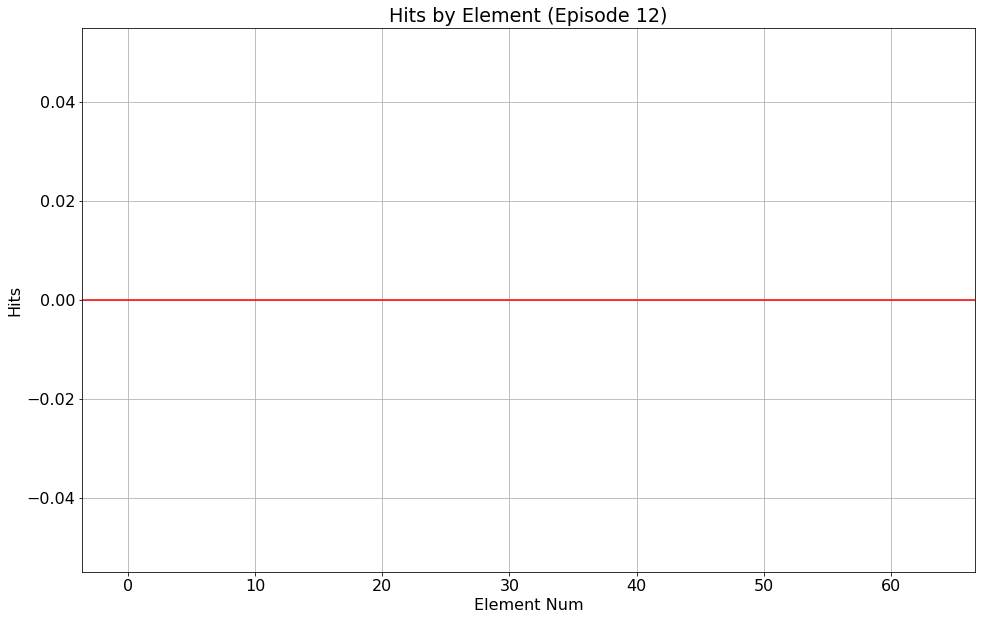


********************************************************************************
Round 4: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   2400
effective_learning_rate=1.526e-05, training_time 108 sec.
Train on 3200 samples
Epoch 49/52
3200/3200 [==============================] - 5s 2ms/sample - loss: -6509023.4300
Epoch 50/52
3200/3200 [==============================] - 2s 620us/sample - loss: -6768847.2300
Epoch 51/52
3200/3200 [==============================] - 2s 639us/sample - loss: -6910259.8600
Epoch 52/52
3200/3200 [==============================] - 2s 642us/sample - loss: -7033668.7900
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    678.42 :   678.42 :      nan arc seconds
Geom Mean Threshold :   5188.03 :  5188.03 :      nan arc seconds
Mean Log Likelihood :     

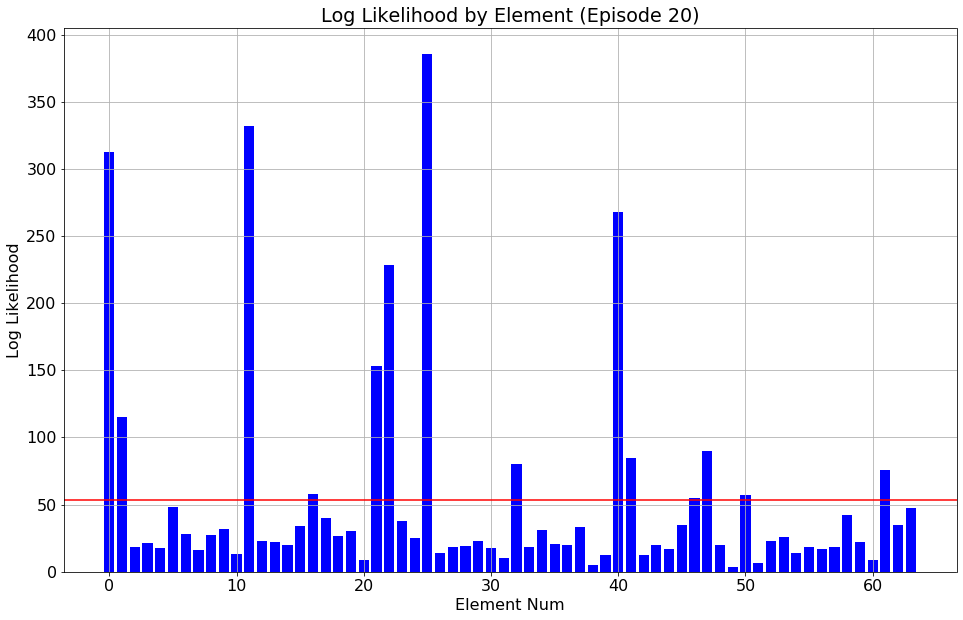

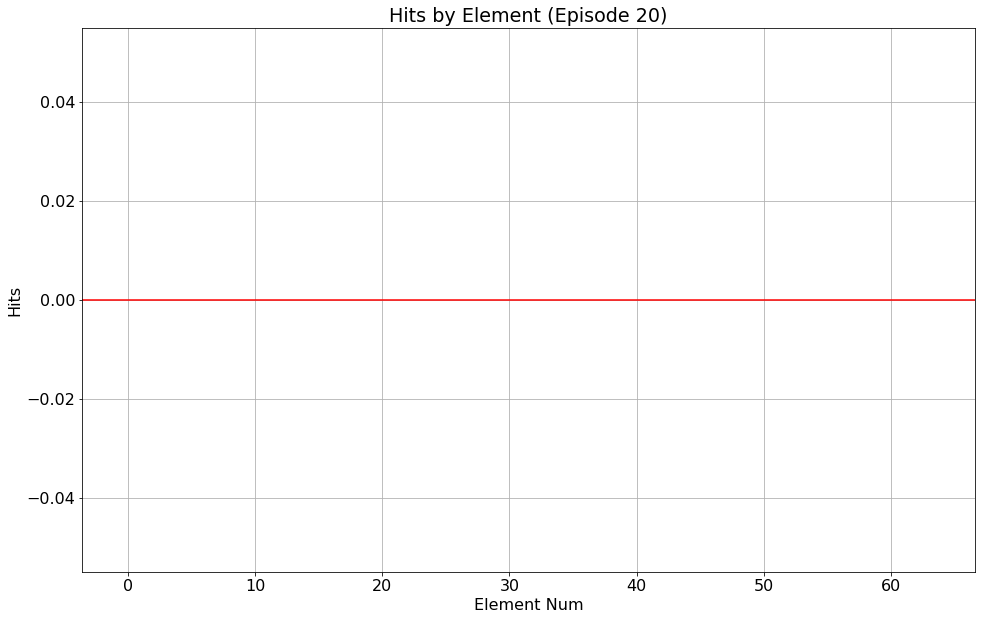


********************************************************************************
Round 5: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   4000
effective_learning_rate=1.493e-05, training_time 184 sec.
Train on 3200 samples
Epoch 81/84
3200/3200 [==============================] - 3s 1ms/sample - loss: -14415073.4400
Epoch 82/84
3200/3200 [==============================] - 2s 548us/sample - loss: -17688651.9800
Epoch 83/84
3200/3200 [==============================] - 2s 506us/sample - loss: -22003278.2000
Epoch 84/84
3200/3200 [==============================] - 1s 425us/sample - loss: -28142453.8400
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    432.82 :   432.82 :      nan arc seconds
Geom Mean Threshold :   3382.52 :  3382.52 :      nan arc seconds
Mean Log Likelihood :     67.00 :    67.00 :      nan
Mean Hits 

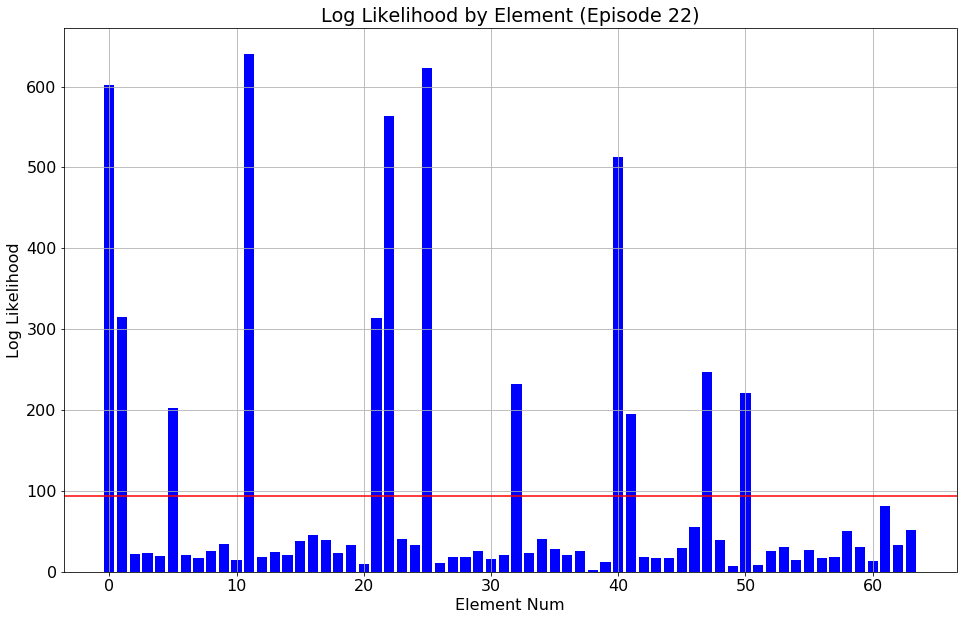

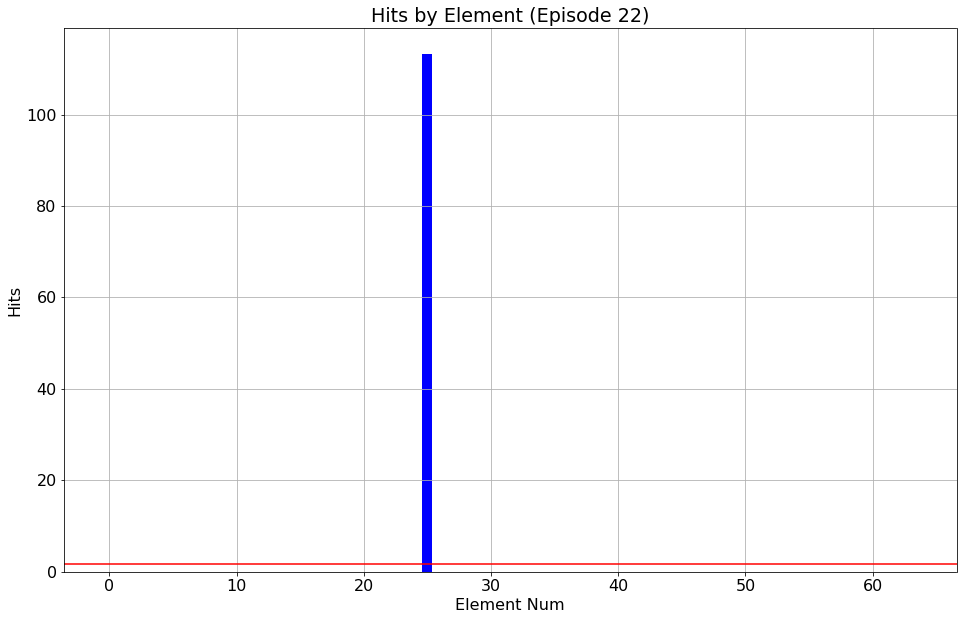


********************************************************************************
Round 6: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   4400
effective_learning_rate=2.422e-04, training_time 202 sec.
Train on 3200 samples
Epoch 89/92
3200/3200 [==============================] - 5s 2ms/sample - loss: -115187448.3200
Epoch 90/92
3200/3200 [==============================] - 2s 633us/sample - loss: -120535226.4000
Epoch 91/92
3200/3200 [==============================] - 2s 680us/sample - loss: -122111298.5600
Epoch 92/92
3200/3200 [==============================] - 2s 647us/sample - loss: -123676634.0800
Adjusted element weight down on 3 candidate elements. Mean weight = 9.55e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    359.09 :   370.03 :    54.20 arc seconds
Geom Me

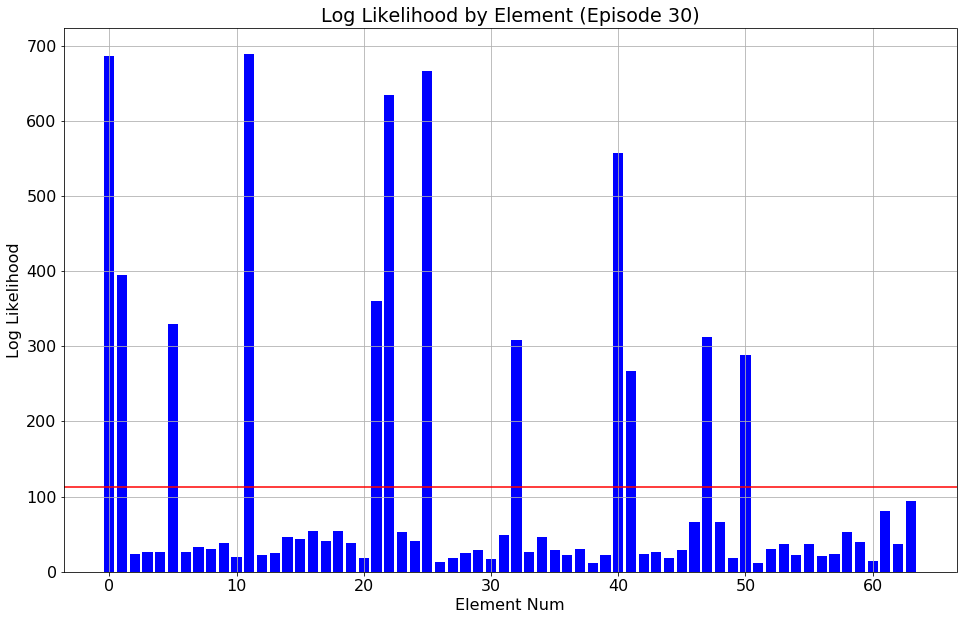

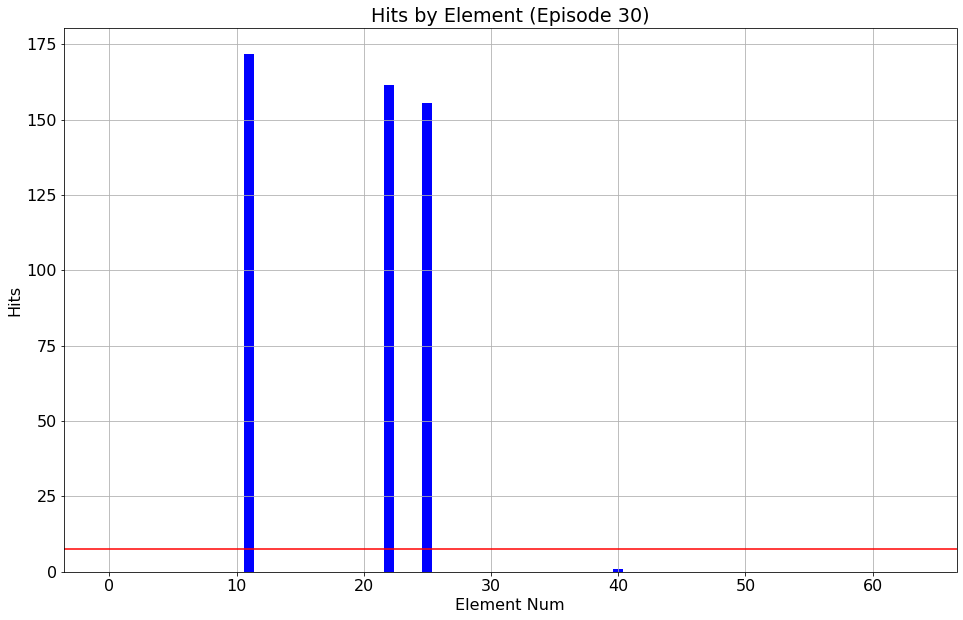


********************************************************************************
Round 7: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3000.0
********************************************************************************

Training episode 30: Epoch  120, Batch   6000
effective_learning_rate=2.441e-04, training_time 283 sec.
Train on 3200 samples
Epoch 121/124
3200/3200 [==============================] - 4s 1ms/sample - loss: -196890794.8800
Epoch 122/124
3200/3200 [==============================] - 2s 477us/sample - loss: -235476000.0000
Epoch 123/124
3200/3200 [==============================] - 2s 558us/sample - loss: -285352518.4000
Epoch 124/124
3200/3200 [==============================] - 2s 550us/sample - loss: -350974384.6400
Adjusted element weight down on 3 candidate elements. Mean weight = 9.77e-01
                    \  All Elts : Bad Elts : Good Elts (5)
Geom Mean Resolution:    283.23 :   335.55 :    38.33 arc seconds
Geom Mean Threshold :   2366.84 :  2634.3

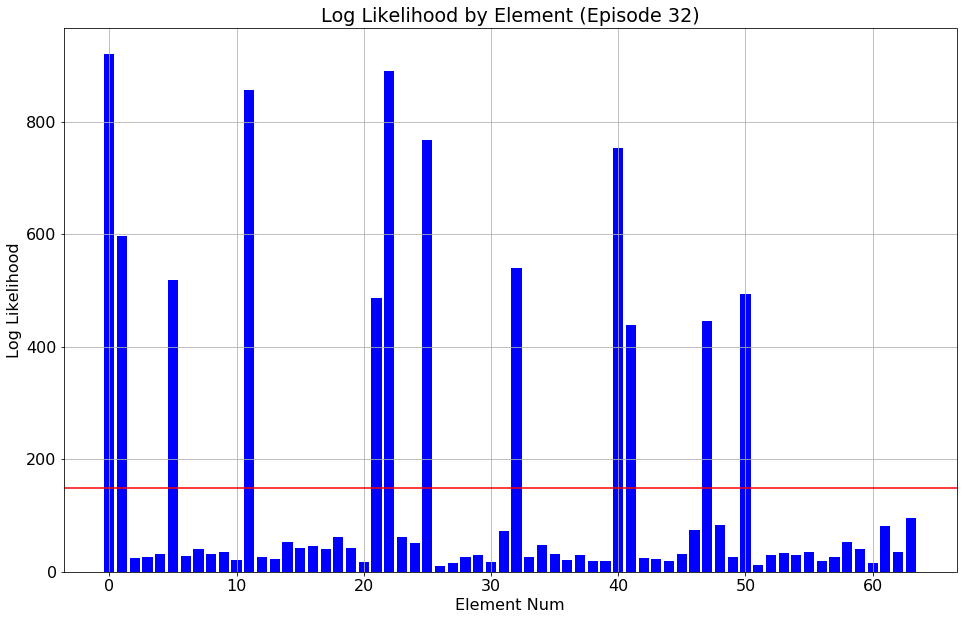

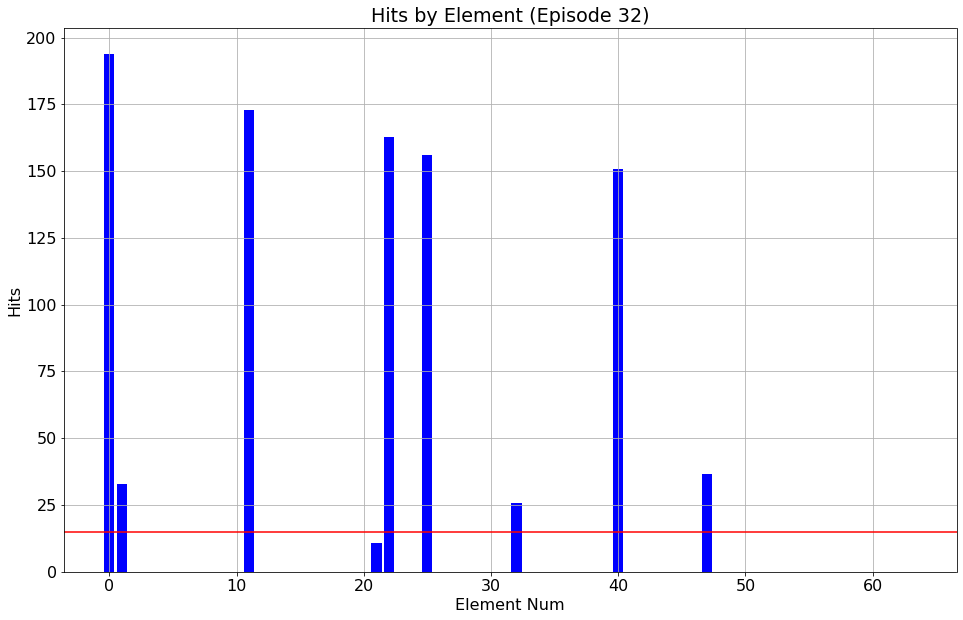


********************************************************************************
Round 8: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 32: Epoch  128, Batch   6400
effective_learning_rate=1.526e-05, training_time 302 sec.
Train on 3200 samples
Epoch 129/132
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 25 candidate elements. Mean weight = 8.05e-01
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    256.85 :   349.60 :    39.04 arc seconds
Geom Mean Threshold :   2135.88 :  2678.72 :   535.24 arc seconds
Mean Log Likelihood :    150.64 :    61.23 :   697.02
Mean Hits           :     15.01 :     0.00 :   106.74
Good Elements       :      9.00

Training episode 33: Epoch  129, Batch   6450
effective_learning_rate=1.228e-05, training_time 309 s

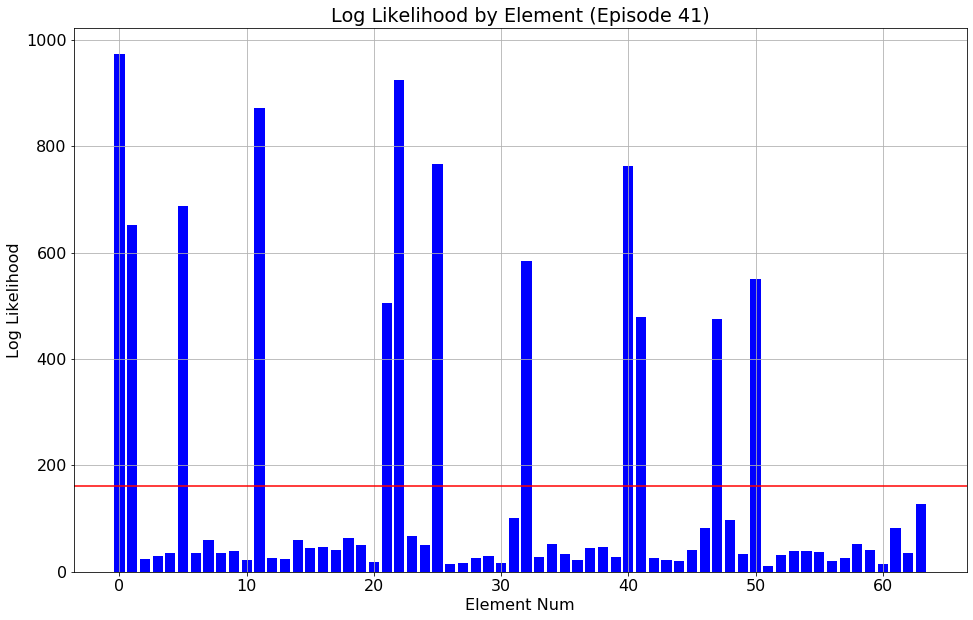

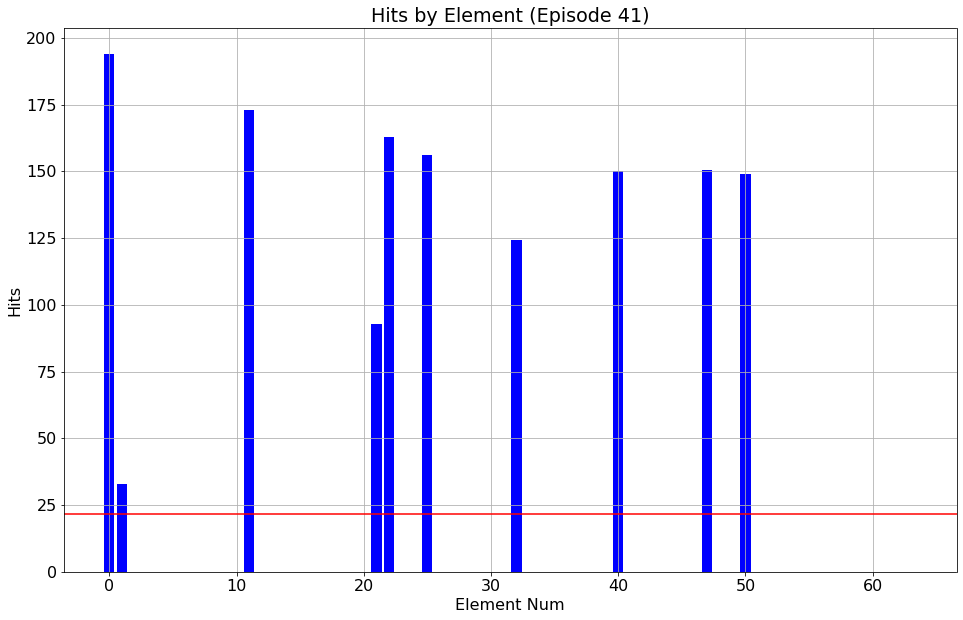


********************************************************************************
Round 9: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 41: Epoch  161, Batch   8050
effective_learning_rate=8.119e-06, training_time 390 sec.
Train on 3200 samples
Epoch 162/165
3200/3200 [==============================] - 3s 1ms/sample - loss: -1479387770.8800
Epoch 163/165
3200/3200 [==============================] - 2s 579us/sample - loss: -1726313548.8000
Epoch 164/165
3200/3200 [==============================] - 2s 598us/sample - loss: -2033363015.6800
Epoch 165/165
3200/3200 [==============================] - 2s 583us/sample - loss: -2420656271.3600
Adjusted element weight down on 9 candidate elements. Mean weight = 8.54e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    234.98 :   384.57 :    27.79 arc seconds
Geom Mean Threshold :   1643.13 :  2

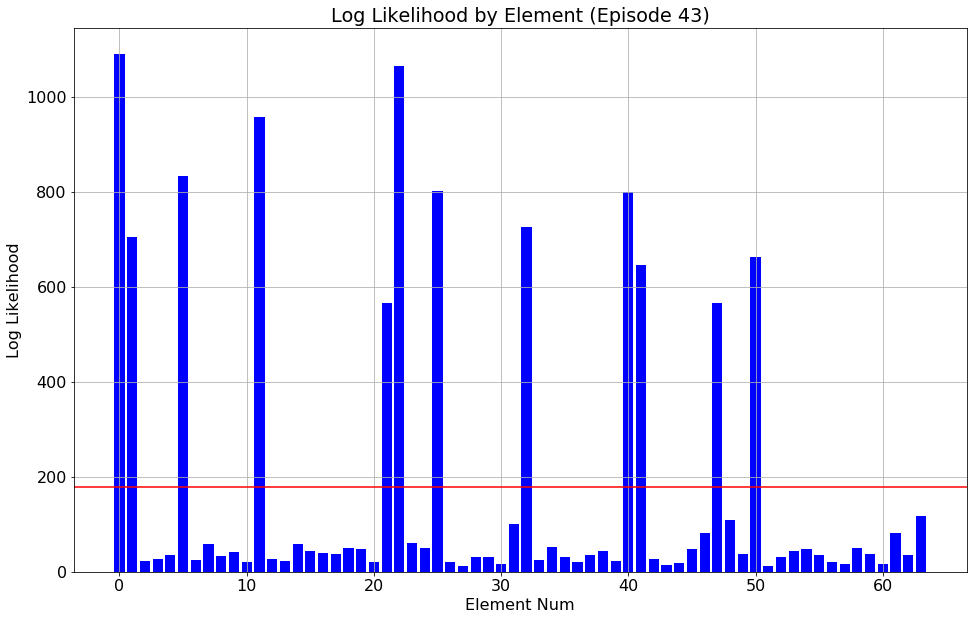

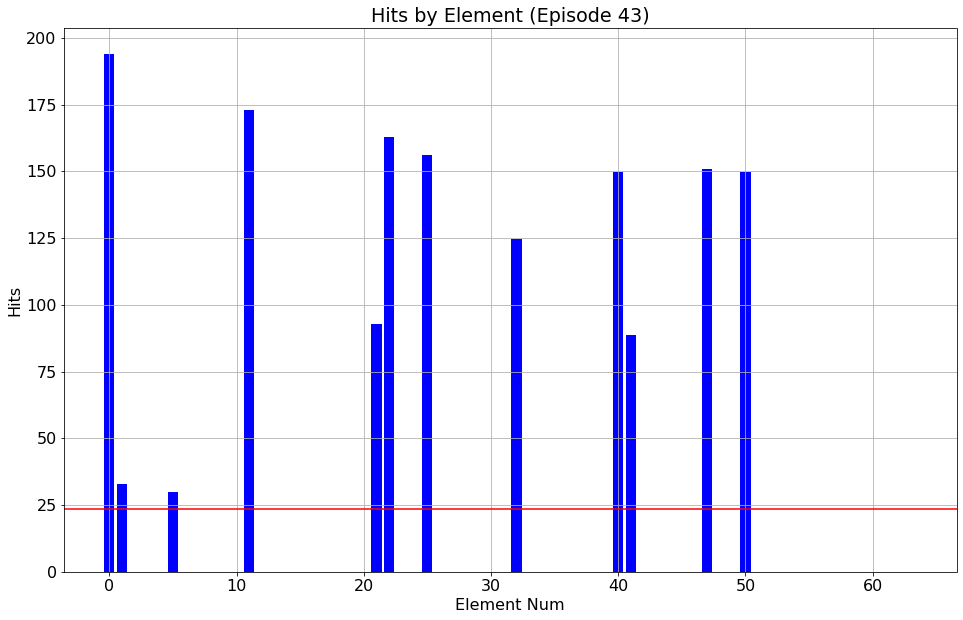


********************************************************************************
Round 10: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 43: Epoch  169, Batch   8450
effective_learning_rate=1.962e-04, training_time 410 sec.
Train on 3200 samples
Epoch 170/173
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 31 candidate elements. Mean weight = 4.13e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    223.08 :   405.44 :    16.75 arc seconds
Geom Mean Threshold :   1515.07 :  2271.79 :   261.85 arc seconds
Mean Log Likelihood :    179.71 :    39.81 :   785.95
Mean Hits           :     23.38 :     0.00 :   124.70
Good Elements       :     12.00

Training episode 44: Epoch  170, Batch   8500
effective_learning_rate=6.295e-06, training_time 416

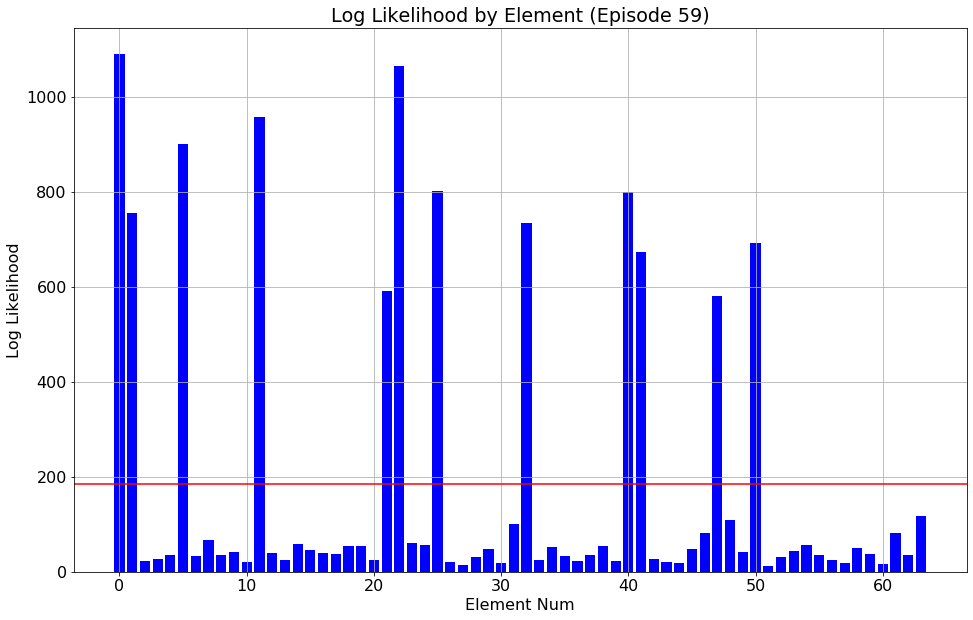

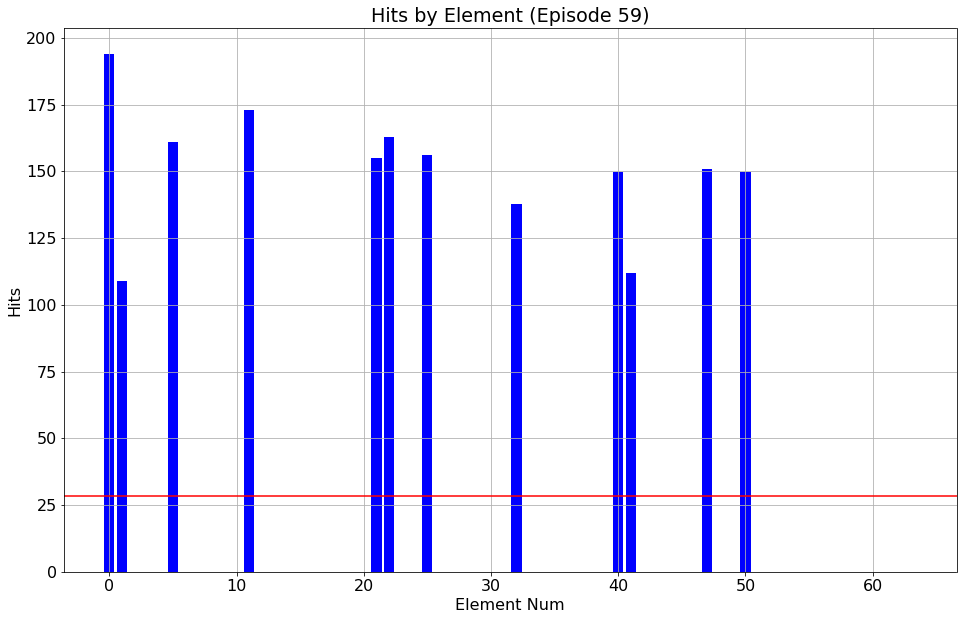


********************************************************************************
Round 11: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 1800.0
********************************************************************************

Training episode 59: Epoch  200, Batch  10000
effective_learning_rate=1.551e-06, training_time 510 sec.
Train on 3200 samples
Epoch 201/204
3200/3200 [==============================] - 4s 1ms/sample - loss: -7212489584.6400
Epoch 202/204
3200/3200 [==============================] - 2s 647us/sample - loss: -8276621588.4800
Epoch 203/204
3200/3200 [==============================] - 2s 647us/sample - loss: -9576574771.2000
Epoch 204/204
3200/3200 [==============================] - 2s 600us/sample - loss: -11144552407.0400
Adjusted element weight down on 11 candidate elements. Mean weight = 7.67e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    205.93 :   402.33 :    11.30 arc seconds
Geom Mean Threshold :   1157.09 :

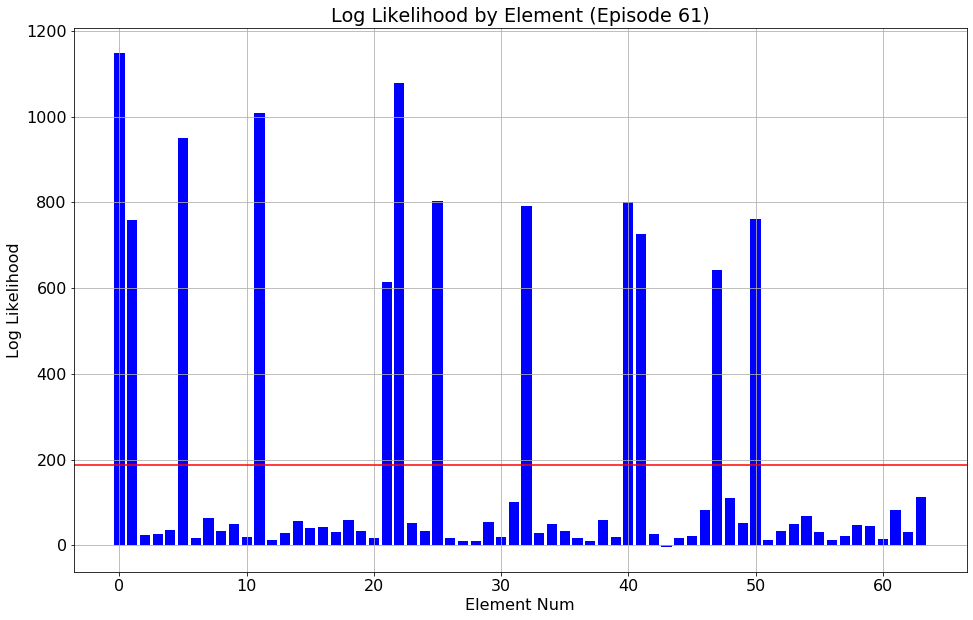

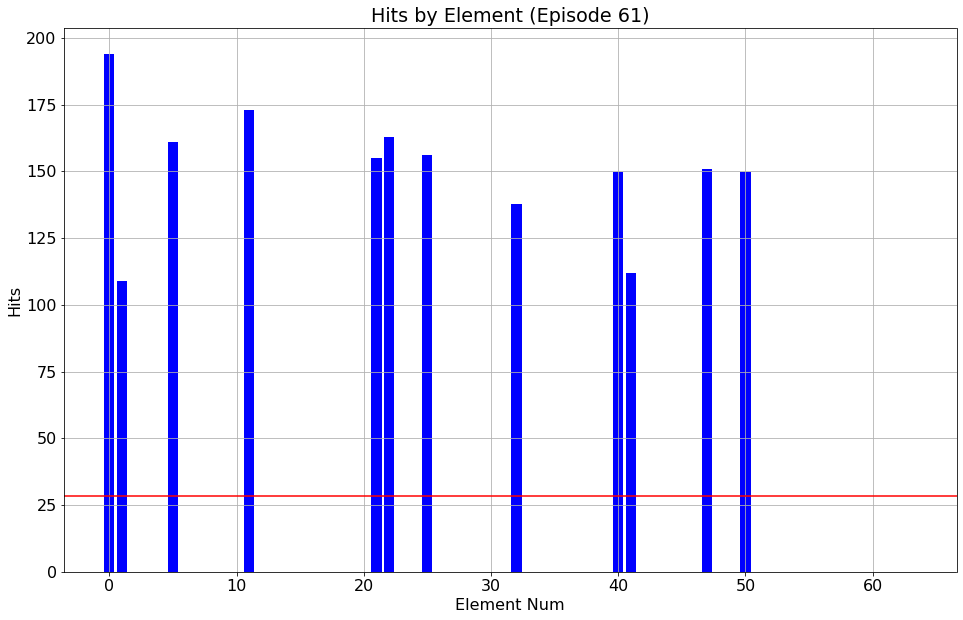


********************************************************************************
Round 12: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 61: Epoch  208, Batch  10400
effective_learning_rate=1.694e-04, training_time 532 sec.
Train on 3200 samples
Epoch 209/212
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 36 candidate elements. Mean weight = 7.18e-02
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    201.26 :   417.99 :     8.48 arc seconds
Geom Mean Threshold :   1108.30 :  1749.33 :   153.37 arc seconds
Mean Log Likelihood :    189.16 :    38.87 :   840.43
Mean Hits           :     28.31 :     0.00 :   150.98
Good Elements       :     12.00

Training episode 62: Epoch  209, Batch  10450
effective_learning_rate=1.096e-06, training_time 539

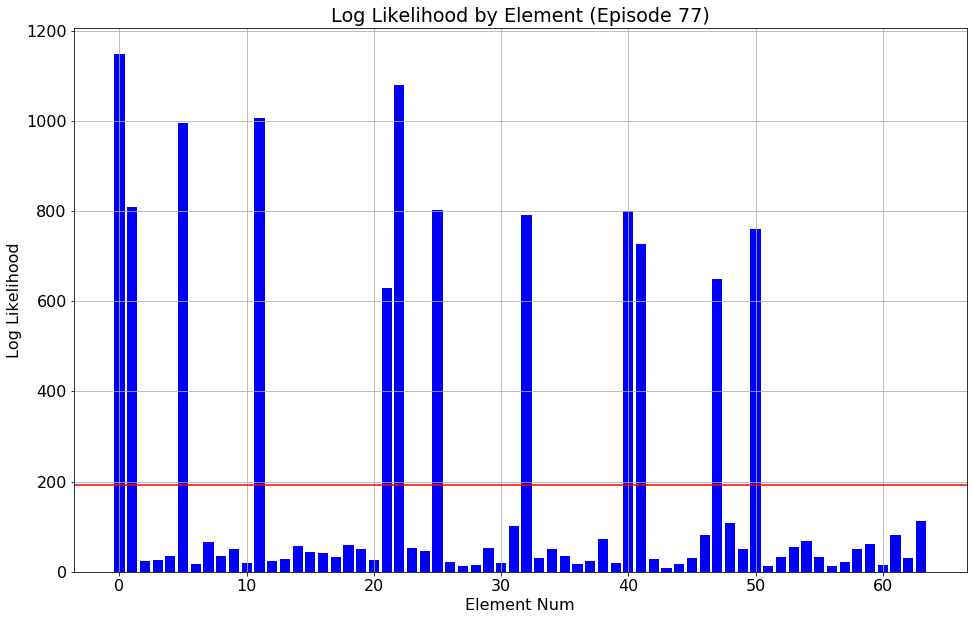

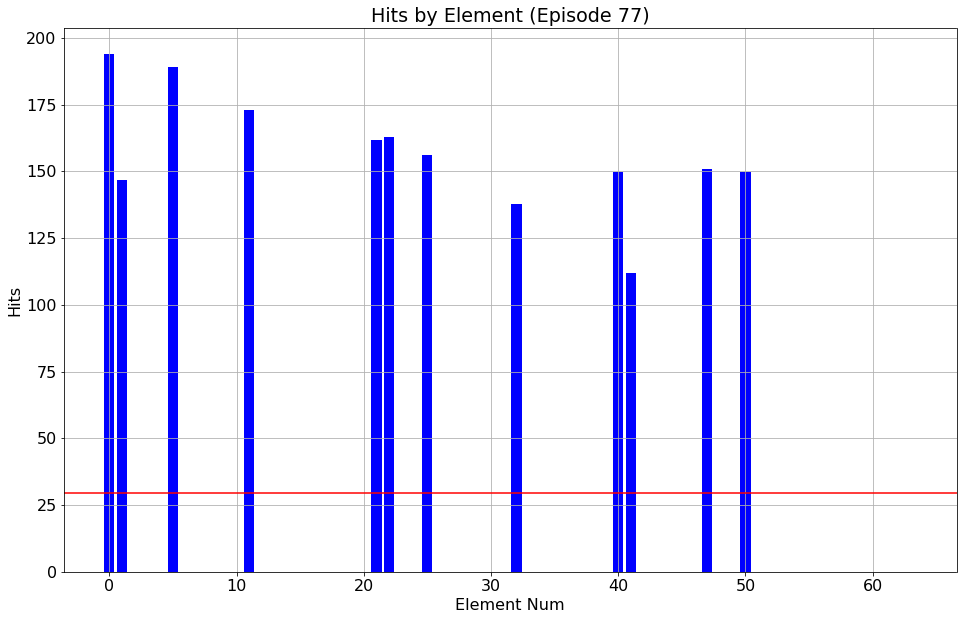


********************************************************************************
Round 7: 1000 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 400.0
********************************************************************************

Training episode 77: Epoch  239, Batch  11950
effective_learning_rate=2.441e-04, training_time 639 sec.
Train on 3200 samples
Epoch 240/243
3200/3200 [==============================] - 4s 1ms/sample - loss: -19011754106.8800
Epoch 241/243
3200/3200 [==============================] - 2s 763us/sample - loss: -20931875225.6000
Epoch 242/243
3200/3200 [==============================] - 2s 759us/sample - loss: -23140535255.0400
Epoch 243/243
3200/3200 [==============================] - 2s 765us/sample - loss: -25699207823.3600
Adjusted element weight down on 16 candidate elements. Mean weight = 8.75e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:     94.43 :   173.30 :     6.80 arc seconds
Geom Mean Threshold :    322.35

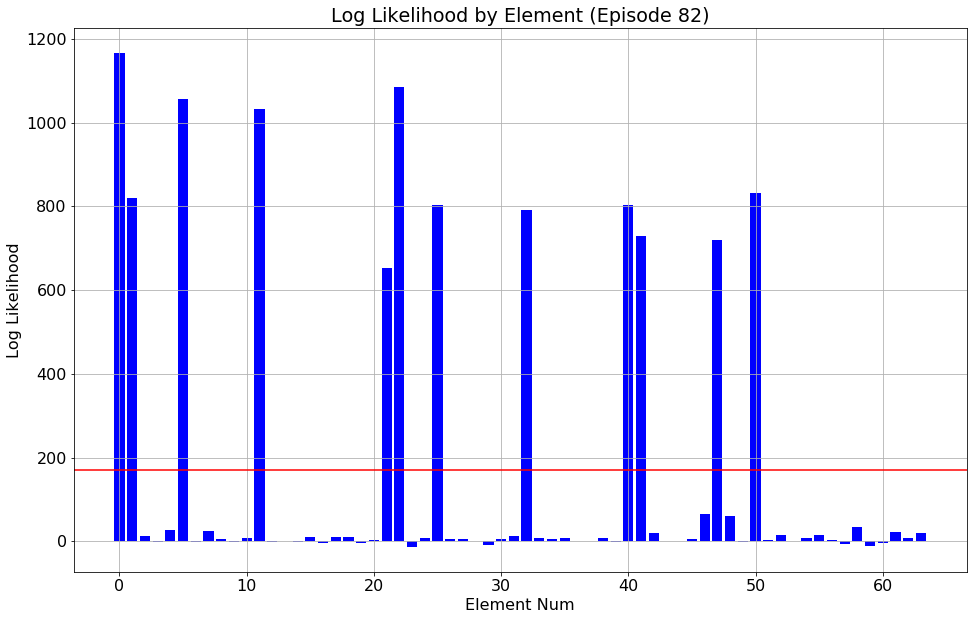

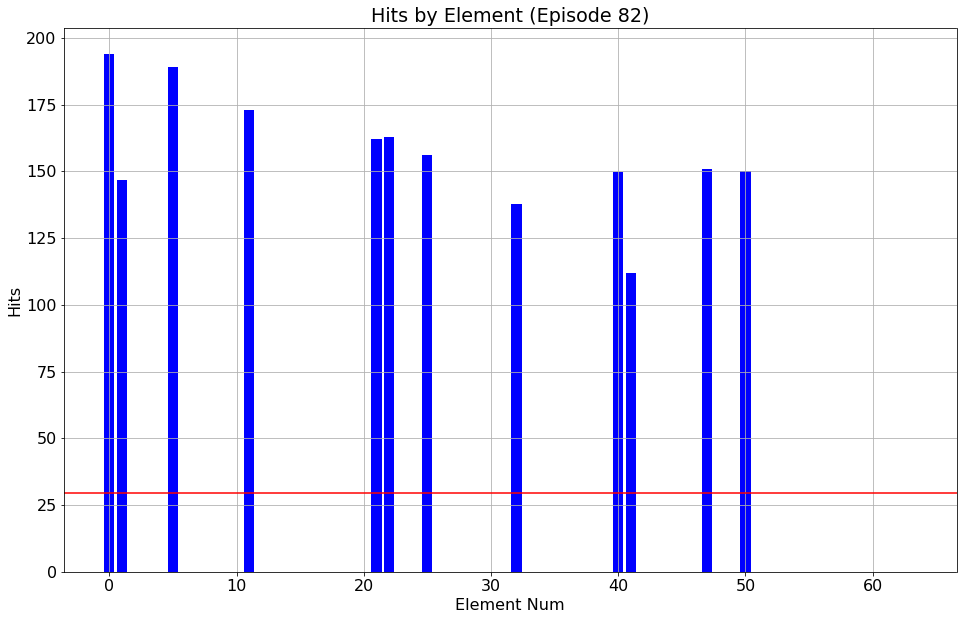


********************************************************************************
Round 8: 4000 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 82: Epoch  259, Batch  12950
effective_learning_rate=3.815e-06, training_time 692 sec.
Train on 3200 samples
Epoch 260/263
3200/3200 [==============================] - 5s 2ms/sample - loss: inf
Adjusted element weight down on 15 candidate elements. Mean weight = 8.83e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:     87.54 :   169.49 :     5.00 arc seconds
Geom Mean Threshold :    308.39 :   395.90 :   104.46 arc seconds
Mean Log Likelihood :    174.00 :    11.61 :   877.67
Mean Hits           :     29.56 :     0.04 :   157.49
Good Elements       :     12.00

Training episode 83: Epoch  260, Batch  13000
effective_learning_rate=3.368e-06, training_time 699 

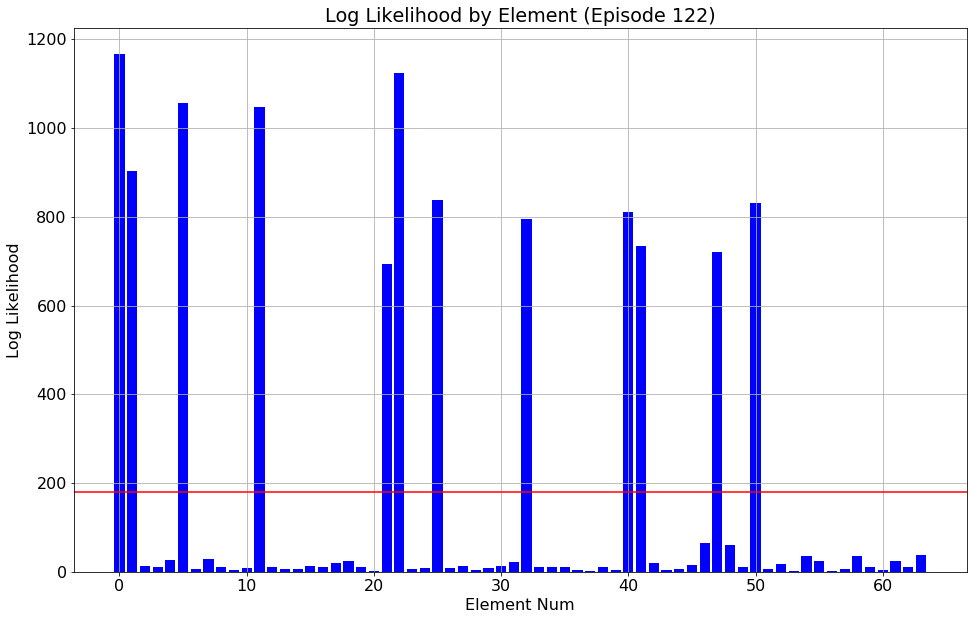

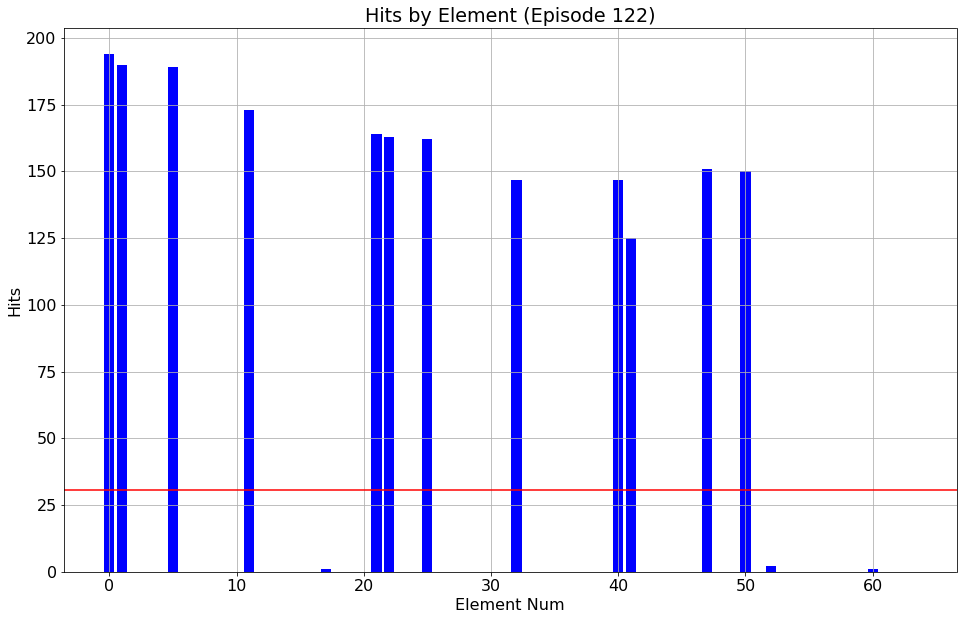


********************************************************************************
Round 9: 2000 batches @ LR 2^-12 in mixture mode.
********************************************************************************

Training episode 122: Epoch  338, Batch  16900
effective_learning_rate=2.441e-04, training_time 970 sec.
Train on 3200 samples
Epoch 339/342
3200/3200 [==============================] - 4s 1ms/sample - loss: -51574381608.9600
Epoch 340/342
3200/3200 [==============================] - 3s 857us/sample - loss: -56594675793.9200
Epoch 341/342
3200/3200 [==============================] - 3s 860us/sample - loss: -62262996992.0000
Epoch 342/342
3200/3200 [==============================] - 3s 853us/sample - loss: -68681074606.0800
Adjusted element weight down on 20 candidate elements. Mean weight = 8.44e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:     79.06 :   155.46 :     4.22 arc seconds
Geom Mean Threshold :    298.87 :   391.87 :    92.40

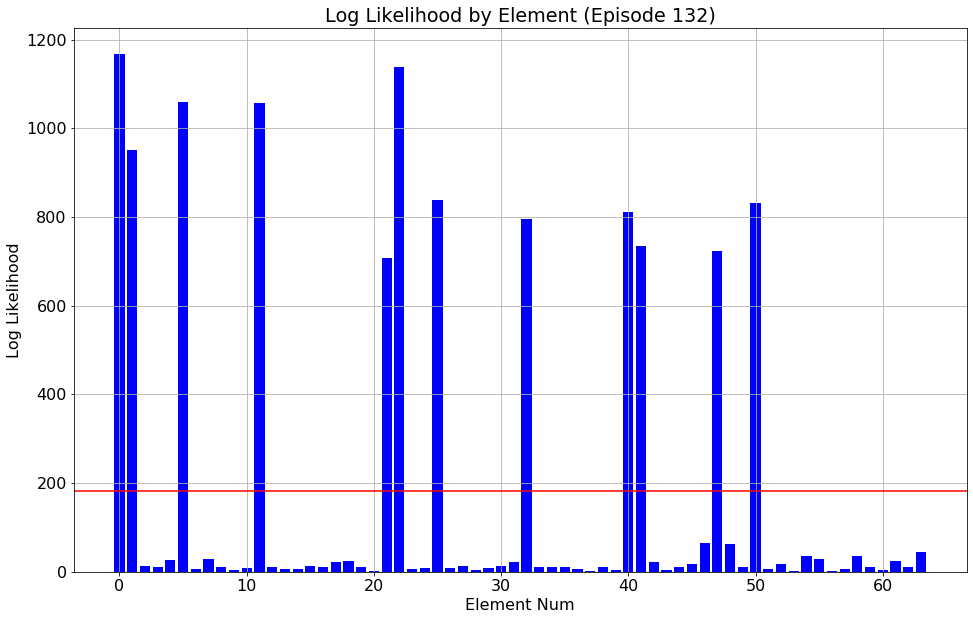

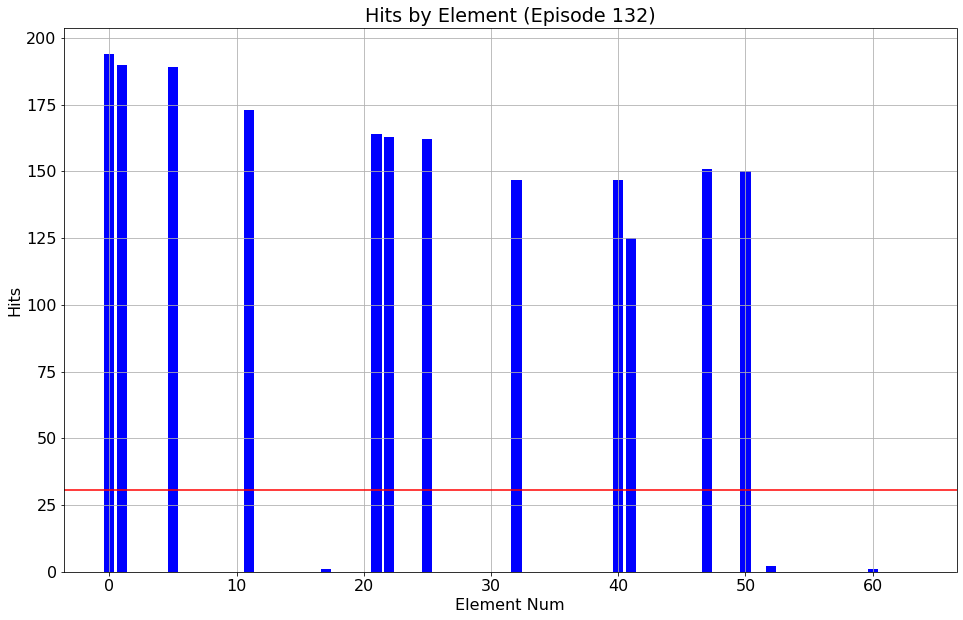

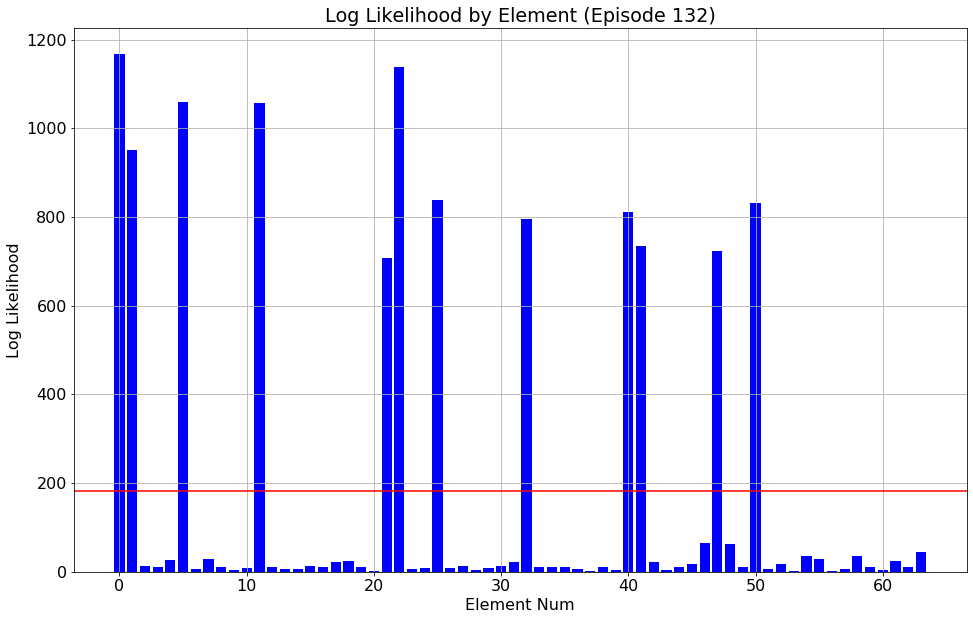

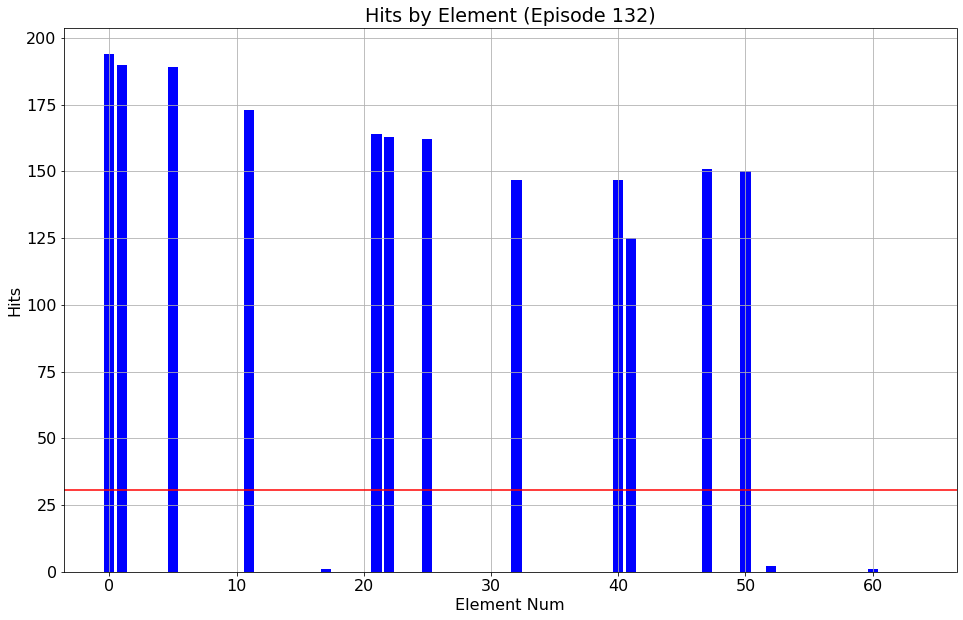

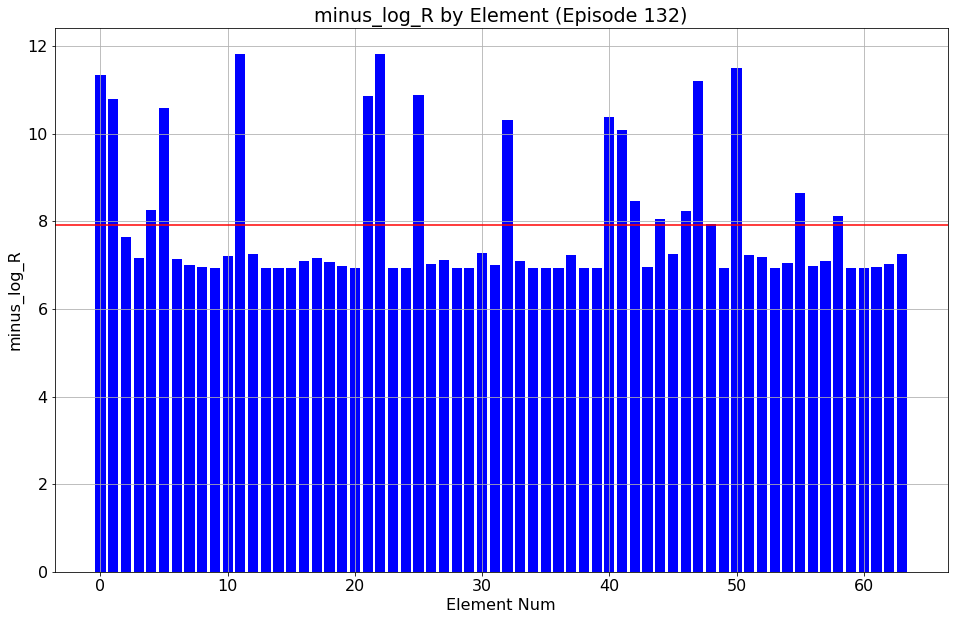

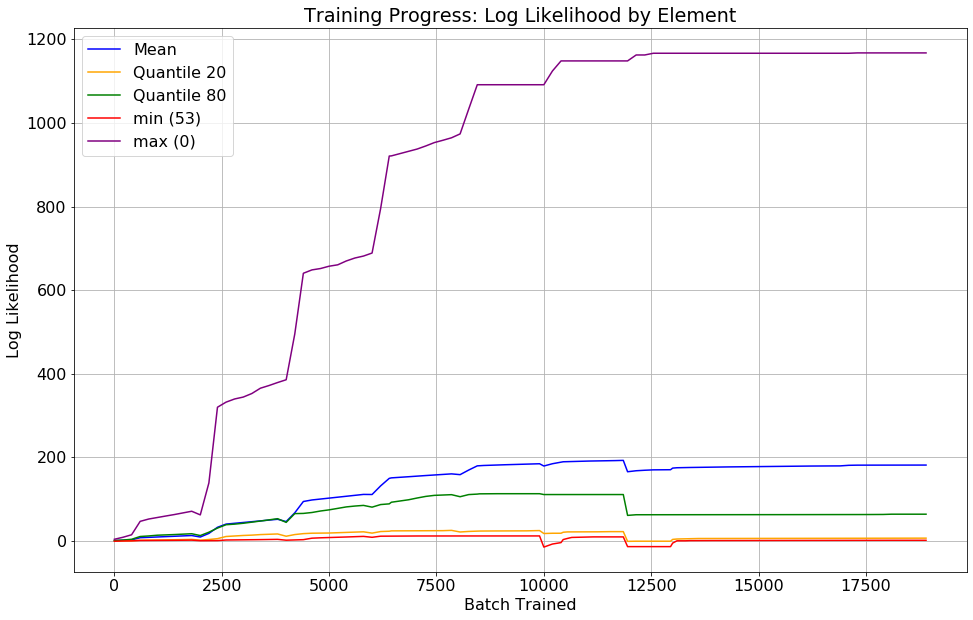

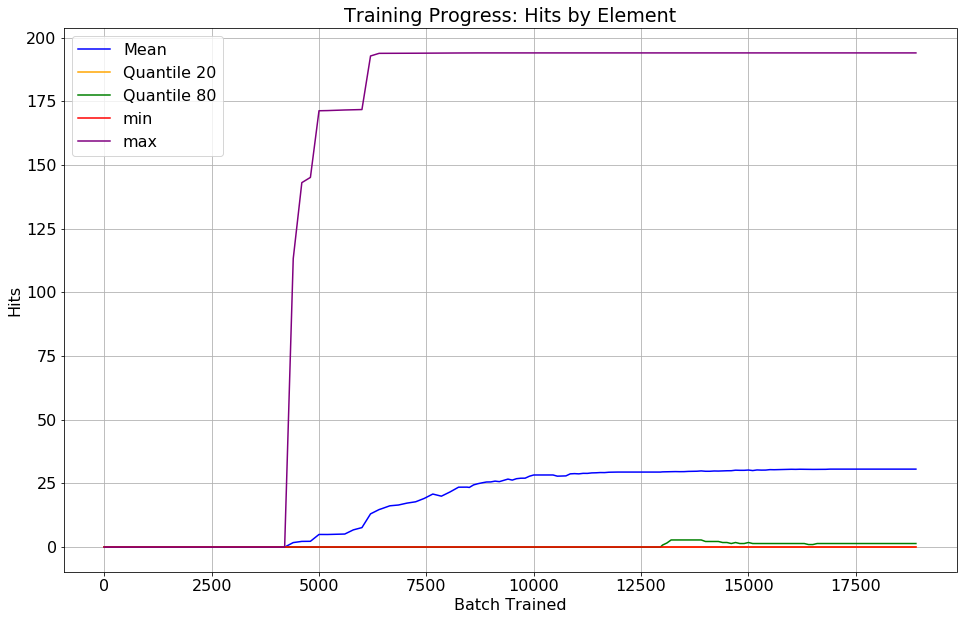

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Sub: Dst tensor is not initialized. [Op:Sub] name: sub/

In [32]:
model.sieve()

In [ ]:
model.report()

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
_ = model.nearest_ast()

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [ ]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
# # Review fitted elements including nearest asteroid
model.elts_fit

In [ ]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)